# Optimización del portafolio tipo sharpe con multiplicadores de Lagrange

## Definición del problema

Se busca optimizar el sharpe ratio de un portafolio mediante el uso de multiplicadores de lagrange. Para ello definimos lo siguiente:

- $w = [w_1,w_2,...,w_n]$ : vector de pesos de los activos del portafolio
- $\mu = [\mu_1,\mu_2,...,\mu_3]$ : vector del valor esperado de cada uno de los activos
- $\Sigma$: la matriz de covarianza de los rendimientos de los activos
- $r_f$: la tasa libre de riesgo
- $1$: vector de unos

El sharpe ratio se define de la siguiente manera:
$$ S = \frac{\mu_p-r_f}{\sigma_p} $$

Suponiendo que tenemos un activo libre de riesgo dentro del portafolio, expresamos el retorno del portafolio de la siguiente manera:
$$ 
\mu_p = (w1^T)\mu + (1-w1^T)r_f = w^T\mu + rf - w^Tr_f
$$

sustituyendo el nuevo valor esperado del portafolio y adaptándolo a nuestro problema se define como:
$$ S = \frac{w^T(\mu - r_f1)}{\sqrt{w^T\Sigma w}} $$

donde:
- $w^T(\mu - r_f1)$ es la rentabilidad del portafolio
- $w^T \Sigma w$ es la varianza del portafolio


## Formulación del problema

Lo que buscamos es
$$ max\; S = \frac{w^T(\mu - r_f1)}{\sqrt{w^T\Sigma w}} $$
$$ s.t. \quad 1^Tw = 1$$

Este problema es complicado de maximizar directamente porque es una fracción con una raíz cuadrada en el denominador. Sin embargo, con una reformulación, podemos simplificar el problema como una maximización del rendimiento regularizando por el factor de la varianza y restándolo.

Por lo tanto planteamos el problema de la siguiente manera:
$$ \max\; w^T(\mu - r_f1) - \lambda(w^T \Sigma w)$$
$$ s.t.\; 1^Tw = 1 $$

Ahora planteamos el problema como una función de Lagrange:

$$\mathcal{L}(w,\lambda) = w^T(\mu - r_f1) - \lambda(w^T \Sigma w)$$

Obtenemos la derivada parcial con respecto a $w$, igualamos a 0 y resolvemos para $w$:

$\frac{\partial \mathcal{L}}{\partial w} = 0 \Rightarrow \mu - r_f1 - 2\lambda \Sigma w = 0$

Despejando obtenemos lo siguiente:

- $w = \frac{1}{2 \lambda} \Sigma^{-1} (\mu - r_f1)$

Utilizando la restricción de igualdad $w1T = 1$, se puede encontrar el valor de $\lambda$:

$$ (\frac{1}{2 \lambda} \Sigma^{-1} (\mu - r_f1))1^T = 1$$
$$ 1^T \Sigma^{-1} (\mu - r_f 1) = 2\lambda $$
$$ \lambda = \frac{1^T \Sigma^{-1} (\mu - r_f 1)}{2} $$

Posteriormente sustituimos $\lambda$ para encontrar el valor óptimo de $w$:

$$ w = \frac{1}{2 \lambda} \Sigma (\mu - r_f1) $$

$$ w = \frac{\Sigma^{-1} (\mu - r_f1)}{2\frac{1^T \Sigma^{-1} (\mu - r_f)}{2}} $$

$$ w = \frac{\Sigma^{-1} (\mu - r_f1)}{1^T \Sigma^{-1} (\mu - r_f1)} $$

## Conclusiones

Ya con esto podemos calcular retorno, el riesgo, y el sharpe del portafolio óptimo con las siguientes fórmulas:

- $R_p = w^{^T}\mu$
- $\sigma_p = \sqrt{ w^{T} \Sigma w}$
- $S = \frac{R_p}{\sigma_p}$

Como en el cálculo de $w$ a $\mu$ ya se le resto $r_f$, para obtener el sharpe ratio no es necesario restar $r_f$ al retorno del portafolio.

Los valores obtenidos para $w$ pueden ser mayores a 1 o menores a 0. Si un valor es mayor que 1, indica que se ha utilizado apalancamiento en esa posición; mientras que si es menor que 0, significa que se ha tomado una posición corta en dicho activo.

Además si se desea modificar el retorno y riesgo esperado del portafolio, este se puede ajustar al multiplicar el vector $w$ por un valor de $\alpha$. A continuación se muestra el código para realizar los cálculos necesarios para obtener el portafolio con el valor del sharpe ratio más alto.


## Fórmula que optimiza el sharpe ratio
$$
w = \frac{\Sigma^{-1} (\mu - r_f 1)}{1^T \Sigma^{-1} (\mu - r_f 1)}
$$

## Código

### Librerías a utilizar

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import display, Markdown
from ipywidgets import interact, FloatSlider

### Descarga de datos

In [2]:
tickers=['AMZN','WMT','GOOGL','AAPL','JPM']

f_inicial='2020-01-01'
f_final='2024-11-10'

datos1=yf.download(tickers,f_inicial,f_final)['Adj Close']

rt = datos1.pct_change().dropna()


[*********************100%***********************]  5 of 5 completed


### Obtención de matrices y vectores importantes

In [3]:
mu = (rt.mean() * 252).values  # Rendimientos esperados
unos = np.ones(len(mu)) # Vector de unos
rf = 0.04413  # Tasa libre de riesgo
sigma = rt.cov().values  # Matriz de covarianzas
sigma_inv = np.linalg.inv(sigma)  # Matriz de varianza-covarianza inversa
mu_rf = mu - np.dot(rf,unos) # Rendimientos esperados en exceso

### Ejecución de la fórmula obtenida

In [4]:
w = np.dot(sigma_inv,mu_rf)/ np.dot(unos.T,np.dot(sigma_inv,mu_rf))
ret = np.dot(w.T, mu)
risk = np.sqrt(np.dot(w.T, np.dot(sigma, w))) * np.sqrt(252)

sharpe = (ret - rf) / risk

w_chat = pd.DataFrame(w, index=tickers, columns=['w'])

print(f'Return: {ret:.6f}')
print(f'Risk: {risk:.6f}')
print(f'Sharpe ratio: {sharpe:.6f}')

display(Markdown(f'Valores del vector $w$:'))

display(w_chat.T)

Return: 0.234595
Risk: 0.214992
Sharpe ratio: 0.885918


Valores del vector $w$:

,AMZN,WMT,GOOGL,AAPL,JPM
w,0.342612,-0.031618,0.153063,0.059,0.476943


Return: 0.234595
Risk: 0.214992
Sharpe ratio: 0.885918

Weights:
AMZN: 0.342612
WMT: -0.031618
GOOGL: 0.153063
AAPL: 0.059000
JPM: 0.476943


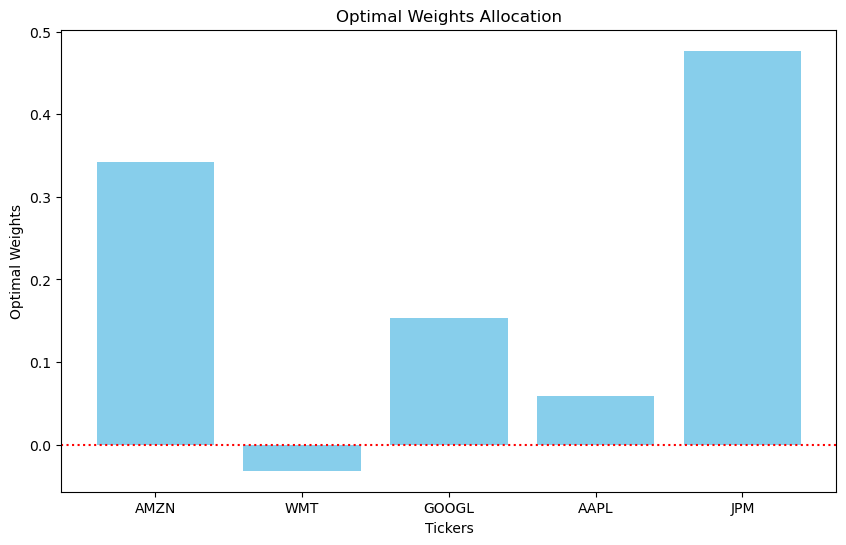

In [5]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, w, color='skyblue')
plt.axhline(0, color='red', linestyle=':')
plt.xlabel('Tickers')
plt.ylabel('Optimal Weights')
plt.title('Optimal Weights Allocation')
print(f'Return: {ret:.6f}')
print(f'Risk: {risk:.6f}')
print(f'Sharpe ratio: {sharpe:.6f}')
print()
print("Weights:")
for ticker, weight in zip(tickers, w):
    print(f"{ticker}: {weight:.6f}")

### Cambios en los pesos de $w^*$ moviendo $\alpha$

Se decide multiplicar el vector $w^*$ por un valor escalar $\alpha$, para ver como cambian los pesos del portafolio y sus métricas.

In [6]:
def update_plot(alpha):
    adjusted_weights = w * alpha
    plt.figure(figsize=(10, 6))
    plt.bar(tickers, adjusted_weights, color='skyblue')
    plt.axhline(0, color='red', linestyle=':')
    plt.xlabel('Tickers')
    plt.ylabel('Optimal Weights')
    plt.title('Optimal Weights Allocation')
    ret = np.dot(adjusted_weights.T, mu_rf)
    risk = np.sqrt(np.dot(adjusted_weights.T, np.dot(sigma, adjusted_weights))) * np.sqrt(252)

    sharpe = ret / risk
    print(f'Return: {ret:.6f}')
    print(f'Risk: {risk:.6f}')
    print(f'Sharpe ratio: {sharpe:.6f}')
    print()
    print("Adjusted Weights:")
    for ticker, weight in zip(tickers, adjusted_weights):
        print(f"{ticker}: {weight:.6f}")
    plt.show()

interact(update_plot, alpha=FloatSlider(value=1, min=0, max=2, step=0.05))



interactive(children=(FloatSlider(value=1.0, description='alpha', max=2.0, step=0.05), Output()), _dom_classes…

<function __main__.update_plot(alpha)>